### 使用Theano并行训练神经网络

In [1]:
%matplotlib inline
# pip install Theano

# 下面是个简单的Theano例子，我们开发Theano代码时，只需要遵循是三个步骤：定义符号（变量对象）、编译代码、执行代码。
import theano
from theano import tensor as T

# initialize
x1 = T.scalar()
w1 = T.scalar()
w0 = T.scalar()
z1 = w1 * x1 + w0

# compile
net_input = theano.function(inputs=[w1, x1, w0], outputs=z1)

# execute
print('Net input: %.2f' %net_input(2.0, 1.0, 0.5))

Net input: 2.50


In [2]:
# 默认是使用双精度浮点格式
print(theano.config.floatX)

float64


In [3]:
theano.config.floatX = 'float32'
print(theano.config.floatX)

float32


In [4]:
# 改变默认值的其他2种方式
# export THEANO_FLAGS=floatX=float32   
# THEANO_FLAGS=floatX=float32 python the_script.py    

In [5]:
print(theano.config.device)

cpu


In [6]:
# 使用GPU运行
# THEANO_FLAGS=device=gpu,floatX=float32 python the_script.py
# echo -e "\n[global]\nfloatX=float32\ndevice=gpu\n" >> ~/.theanorc 

In [7]:
import numpy as np

# initialize
x = T.fmatrix(name='x')
x_sum = T.sum(x, axis=0)

# compile
calc_sum = theano.function(inputs=[x], outputs=x_sum)

# execute (Python list)
ary = [[1, 2, 3], [1, 2, 3]]
print('Column sum:', calc_sum(ary))

Column sum: [ 2.  4.  6.]


In [8]:
# execute (numpy array)
ary = np.array([[1,2,3], [1,2,3]], dtype=theano.config.floatX)
print('Column sum:', calc_sum(ary))

Column sum: [ 2.  4.  6.]


In [9]:
print(x)
print(x.type)

x
TensorType(float32, matrix)


In [10]:
# initialize
x = T.fmatrix('x')
w = theano.shared(np.asarray([[0.0, 0.0, 0.0]], dtype=theano.config.floatX))
z = x.dot(w.T)
update = [[w, w + 1.0]]
# 定义了一个变量update，每次迭代后，数组w加1以更新，可以将update传入theano

# compile
net_input = theano.function(inputs=[x], updates=update, outputs=z)

# execute
data = np.array([[1,2,3]], dtype=theano.config.floatX)
for i in range(5):
    print('z%d: '% i, net_input(data))

z0:  [[ 0.]]
z1:  [[ 6.]]
z2:  [[ 12.]]
z3:  [[ 18.]]
z4:  [[ 24.]]


In [11]:
# initialize
data = np.array([[1, 2, 3]], dtype=theano.config.floatX)
x = T.fmatrix('x')
w = theano.shared(np.asarray([[0.0, 0.0, 0.0]], dtype=theano.config.floatX))
z = x.dot(w.T)
update = [[w, w+1.0]]

# compile
# 我们使用inputs数据会在CPU和GPU之间多次传输，可以使用givens将数据加载到GPU内存中。
net_input = theano.function(inputs=[],  updates=update,  givens={x: data},  outputs=z)

# execute
for i in range(5):
    print('z: ', net_input())

z:  [[ 0.]]
z:  [[ 6.]]
z:  [[ 12.]]
z:  [[ 18.]]
z:  [[ 24.]]


In [12]:
# Linear Regression Example

X_train = np.asarray([[0.0], [1.0], [2.0], [3.0], [4.0], [5.0], [6.0], [7.0], [8.0], [9.0]],
                     dtype=theano.config.floatX)
y_train = np.asarray([1.0,  1.3,  3.1,  2.0,  5.0,  6.3,  6.6,  7.4,  8.0,  9.0],
                     dtype=theano.config.floatX)

In [13]:
import theano
from theano import tensor as T
import numpy as np


def train_linreg(X_train, y_train, eta, epochs):
    costs = []
    # initialize arrays
    eta0 = T.scalar('eta0')
    y = T.fvector('y')
    X = T.fmatrix('X')
    w = theano.shared(np.zeros(shape=(X_train.shape[1] + 1), dtype=theano.config.floatX), name='w')

    # calculate cost
    net_input = T.dot(X, w[1:]) + w[0]
    errors = y - net_input
    cost = T.sum(T.pow(errors, 2))

    # perform gradient update
    gradient = T.grad(cost, wrt=w)
    update = [(w, w - eta0 * gradient)]

    # compile model
    train = theano.function(inputs=[eta0], outputs=cost, updates=update, givens={X: X_train, y: y_train})

    for _ in range(epochs):
        costs.append(train(eta))

    return costs, w

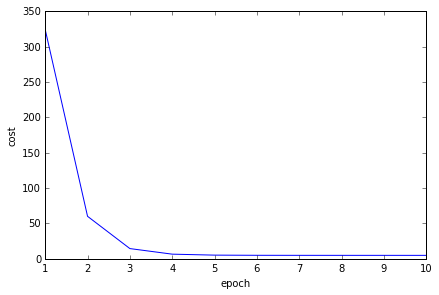

In [14]:
import matplotlib.pyplot as plt
costs,w = train_linreg(X_train, y_train, eta=0.001, epochs=10)
plt.plot(range(1, len(costs)+1), costs)
plt.tight_layout()
plt.xlabel('epoch')
plt.ylabel('cost')
plt.show()

In [15]:
# 预测函数
def predict_linreg(X, w):
    Xt = T.matrix(name='X')
    net_input = T.dot(Xt, w[1:]) + w[0]
    predict = theano.function(inputs=[Xt], givens={w: w}, outputs=net_input)
    
    return predict(X)

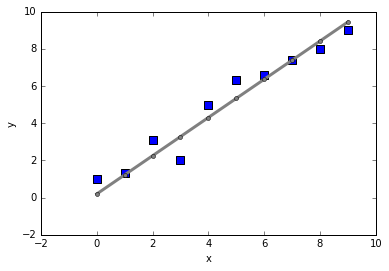

In [16]:
plt.scatter(X_train, y_train, marker='s', s=50)
# print('Xtrain.shape: ', X_train.shape, '\n Predict_linreg: ', predict_linreg(X_train, w))
plt.plot(range(X_train.shape[0]), predict_linreg(X_train, w), 
        color='gray', 
        marker='o', 
        markersize=4, 
        linewidth=3)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [17]:
X = np.array([[1.0,  1.4,  1.5]])
w = np.array([0.0, 0.2, 0.4])

def net_input(X, w):
    z = X.dot(w)
    return z

def logistic(z):
    return 1.0 / (1.0 + np.exp(-z))

def logistic_activation(X, w):
    z = net_input(X, w)
    return logistic(z)

print('P(y=1|x) = %.3f' % logistic_activation(X, w)[0])

P(y=1|x) = 0.707


In [18]:
W = np.array([[1.1, 1.2, 1.3, 0.5], 
             [0.1, 0.2, 0.4, 0.1], 
             [0.2, 0.5, 2.1, 1.9]])
A = np.array([[1.0], 
             [0.1], 
             [0.3], 
             [0.7]])
Z = W.dot(A)
y_probas = logistic(Z)

print('Probabilities:\n', y_probas)

Probabilities:
 [[ 0.87653295]
 [ 0.57688526]
 [ 0.90114393]]


In [19]:
y_class = np.argmax(Z, axis=0)
print('predicted class label: %d' % y_class[0])

predicted class label: 2


In [20]:
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z))

def softmax_activation(X, w):
    z = net_input(X, w)
    return softmax(z)

y_probas = softmax(Z)
print('Probabilities:\n', y_probas)

Probabilities:
 [[ 0.40386493]
 [ 0.07756222]
 [ 0.51857284]]


In [21]:
y_probas.sum()

1.0

In [22]:
y_class = np.argmax(Z, axis=0)
print('predicted class label: %d' % y_class[0])

predicted class label: 2


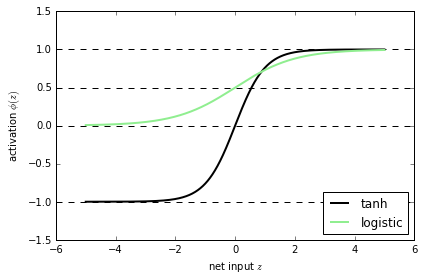

In [23]:
def tanh(z):
    e_p = np.exp(z) 
    e_m = np.exp(-z)
    return (e_p - e_m) / (e_p + e_m)  

import matplotlib.pyplot as plt

z = np.arange(-5, 5, 0.005)
log_act = logistic(z)
tanh_act = tanh(z)

# alternatives:
# from scipy.special import expit
# log_act = expit(z)
# tanh_act = np.tanh(z)

plt.ylim([-1.5, 1.5])
plt.xlabel('net input $z$')
plt.ylabel('activation $\phi(z)$')
plt.axhline(1, color='black', linestyle='--')
plt.axhline(0.5, color='black', linestyle='--')
plt.axhline(0, color='black', linestyle='--')
plt.axhline(-1, color='black', linestyle='--')

plt.plot(z, tanh_act, 
         linewidth=2, 
         color='black', 
         label='tanh')
plt.plot(z, log_act, 
         linewidth=2, 
         color='lightgreen', 
         label='logistic')

plt.legend(loc='lower right')
plt.tight_layout()

plt.show()
# tanh和sigmoid函数曲线对比

### 使用Keras训练神经网络

In [24]:
import os
import struct
import numpy as np

def load_mnist(path, kind='train'):
    """Load MNIST data from 'path'"""
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte'%kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte'%kind)
    with open(labels_path,  'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)
    with open(images_path, 'rb') as imgpath:
        masgic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)

    return images, labels

In [25]:
X_train, y_train = load_mnist('mnist', kind='train')
print('Rows: %d, columns: %d'%(X_train.shape[0], X_train.shape[1]))

Rows: 60000, columns: 784


In [26]:
X_test, y_test = load_mnist('mnist', kind='t10k')
print('Rows: %d, columns: %d'%(X_test.shape[0], X_test.shape[1]))

Rows: 10000, columns: 784


In [27]:
import theano
theano.config.floatX = 'float32'
X_train = X_train.astype(theano.config.floatX)
y_train = y_train.astype(theano.config.floatX)

In [28]:
from keras.utils import np_utils
print('First 3 labels: ', y_train[:3])

Using TensorFlow backend.


First 3 labels:  [ 5.  0.  4.]


In [29]:
# 转换类标为独热码格式。
y_train_ohe = np_utils.to_categorical(y_train)
print('First 3 labels (one-hot): ', y_train_ohe[:3])

First 3 labels (one-hot):  [[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]]


In [30]:
# Keras实现神经网络
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD

np.random.seed(1)

model = Sequential()
# 使用relu
model.add(Dense(50, input_dim=X_train.shape[1], 
               kernel_initializer='uniform', 
               activation='relu'))

model.add(Dense(50, input_dim=50, 
               kernel_initializer='uniform', 
               activation='relu'))

model.add(Dense(y_train_ohe.shape[1], input_dim=50, 
               kernel_initializer='uniform', 
               activation='softmax'))

sgd = SGD(lr=0.001, decay=1e-7, momentum=.9)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=["accuracy"])

In [31]:
model.fit(X_train,
          y_train_ohe,
          epochs=50,
          batch_size=300,
          verbose=1,
          validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 1s 18us/step - loss: 0.5605 - acc: 0.8229 - val_loss: 0.2229 - val_acc: 0.9352
Epoch 2/50
54000/54000 [==============================] - 1s 13us/step - loss: 0.2374 - acc: 0.9282 - val_loss: 0.1710 - val_acc: 0.9503
Epoch 3/50
54000/54000 [==============================] - 1s 13us/step - loss: 0.1841 - acc: 0.9441 - val_loss: 0.1495 - val_acc: 0.9580
Epoch 4/50
54000/54000 [==============================] - 1s 13us/step - loss: 0.1541 - acc: 0.9535 - val_loss: 0.1287 - val_acc: 0.9643
Epoch 5/50
54000/54000 [==============================] - 1s 13us/step - loss: 0.1345 - acc: 0.9597 - val_loss: 0.1229 - val_acc: 0.9662
Epoch 6/50
54000/54000 [==============================] - 1s 13us/step - loss: 0.1198 - acc: 0.9645 - val_loss: 0.1150 - val_acc: 0.9657
Epoch 7/50
54000/54000 [==============================] - 1s 13us/step - loss: 0.1076 - acc: 0.9679 - val_loss: 0.1160 - val_acc:

In [32]:
y_train_pred = model.predict_classes(X_train, verbose=0)
print('First 3 predictions: ', y_train_pred[:3])

First 3 predictions:  [5 0 4]


In [33]:
train_acc = np.sum(y_train==y_train_pred,axis=0) / X_train.shape[0]
print('Training accuracy: %.2f%%' % (train_acc * 100))

Training accuracy: 99.74%


In [34]:
y_test_pred = model.predict_classes(X_test, verbose=0)
test_acc = np.sum(y_test==y_test_pred,axis=0) / X_test.shape[0]
print('Test accuracy: %.2f%%'% (test_acc * 100))

Test accuracy: 97.26%
